Raw shape: (4967, 11)
Columns: ['airfoil_id', 'polar_id', 'Re', 'max_thickness', 'x_at_max_thickness', 'max_camber', 'x_at_max_camber', 'max_cl', 'alpha_at_max_cl', 'sharpness_rating', 'radius_rating']
After cleaning: (4916, 11)
X shape: (4916, 7)
y shape: (4916,)
k   MAE    RMSE   R²
3    0.181  0.247  0.294
5    0.174  0.236  0.360
7    0.173  0.232  0.379
9    0.171  0.230  0.390
11   0.170  0.230  0.392
15   0.170  0.229  0.395

Best k by R²: 15

Final kNN (k=15) performance:
MAE  (deg): 0.170
RMSE (deg): 0.229
R²         : 0.395


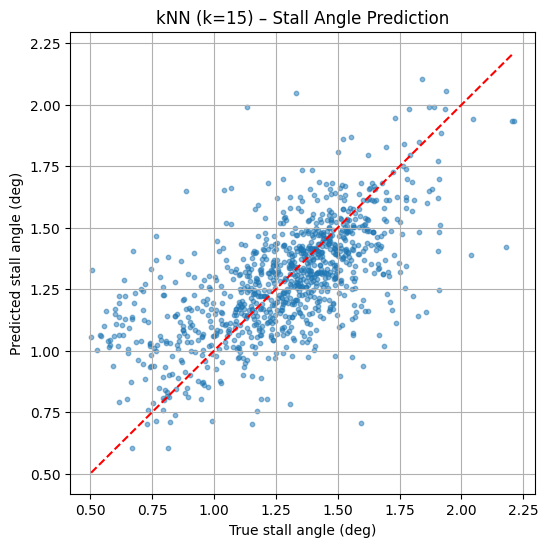

In [3]:
# === kNN Regression for Stall Angle Prediction (all-in-one cell) ===
# This cell: loads data, cleans it, builds features, trains kNN, evaluates, and plots.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------------------------------------------
# 1) Load CSV
# ---------------------------------------------------------------------
csv_path = "airfoil_geometry_and_angel_of_stall_data.csv"   # change if needed
df = pd.read_csv(csv_path)
print("Raw shape:", df.shape)
print("Columns:", list(df.columns))

# ---------------------------------------------------------------------
# 2) Define target and feature columns
# ---------------------------------------------------------------------
# Target (stall angle). Change this if your column name differs.
STALL_COL = "max_cl"

# Base features (7 parameters)
FEATURE_COLS = [
    "Re",
    "max_thickness",
    "x_at_max_thickness",
    "max_camber",
    "x_at_max_camber",
    "sharpness_rating",
    "radius_rating",
]

# ---------------------------------------------------------------------
# 3) Clean the stall-angle column and base features
# ---------------------------------------------------------------------
if STALL_COL not in df.columns:
    raise ValueError(f"Stall column '{STALL_COL}' not found. Available: {list(df.columns)}")

# Clean text entries in the stall column like "not reached"
df[STALL_COL] = (
    df[STALL_COL]
    .astype(str)
    .str.strip()
    .replace({
        "not reached": np.nan,
        "have not reached": np.nan,
        "Not reached": np.nan,
        "Have not reached": np.nan,
        "-": np.nan,
    })
)

# Convert stall angle to numeric (bad text -> NaN)
df[STALL_COL] = pd.to_numeric(df[STALL_COL], errors="coerce")

# Make sure all feature columns exist
missing = [c for c in FEATURE_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected feature columns: {missing}")

# Convert features to numeric
for col in FEATURE_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=FEATURE_COLS + [STALL_COL]).copy()

# Optional: remove bogus very small stall angles (often XFOIL artifacts)
df_clean = df_clean[df_clean[STALL_COL] > 0.5]

print("After cleaning:", df_clean.shape)

# ---------------------------------------------------------------------
# 4) Build X and y
# ---------------------------------------------------------------------
X = df_clean[FEATURE_COLS].values.astype(np.float32)
y = df_clean[STALL_COL].values.astype(np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

# ---------------------------------------------------------------------
# 5) Train/validation split
# ---------------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------------------
# 6) Scale features (VERY important for kNN)
# ---------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# ---------------------------------------------------------------------
# 7) Try a few different k values and pick the best
# ---------------------------------------------------------------------
k_values = [3, 5, 7, 9, 11, 15]
results = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")  # distance-weighted kNN
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_val_scaled)
    mae_k  = mean_absolute_error(y_val, y_pred_k)
    rmse_k = np.sqrt(mean_squared_error(y_val, y_pred_k))
    r2_k   = r2_score(y_val, y_pred_k)
    results.append((k, mae_k, rmse_k, r2_k))

print("k   MAE    RMSE   R²")
for k, mae_k, rmse_k, r2_k in results:
    print(f"{k:<3d} {mae_k:6.3f} {rmse_k:6.3f} {r2_k:6.3f}")

# Pick k with best R²
best_k, best_mae, best_rmse, best_r2 = max(results, key=lambda x: x[3])
print("\nBest k by R²:", best_k)

# ---------------------------------------------------------------------
# 8) Train final kNN model with best k
# ---------------------------------------------------------------------
best_knn = KNeighborsRegressor(n_neighbors=best_k, weights="distance")
best_knn.fit(X_train_scaled, y_train)
y_pred = best_knn.predict(X_val_scaled)

# Evaluate
mae  = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2   = r2_score(y_val, y_pred)

print(f"\nFinal kNN (k={best_k}) performance:")
print(f"MAE  (deg): {mae:.3f}")
print(f"RMSE (deg): {rmse:.3f}")
print(f"R²         : {r2:.3f}")

# ---------------------------------------------------------------------
# 9) Plot predicted vs true stall angle
# ---------------------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, s=10, alpha=0.5)
min_v = min(y_val.min(), y_pred.min())
max_v = max(y_val.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--")
plt.xlabel("True stall angle (deg)")
plt.ylabel("Predicted stall angle (deg)")
plt.title(f"kNN (k={best_k}) – Stall Angle Prediction")
plt.grid(True)
plt.show()
